In [1]:
%matplotlib nbagg 

In [2]:
# import all plotting packages
import matplotlib.pyplot as plt
from matplotlib import colors, cm, animation
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [3]:
# importing system packages
import os
import sys
import time
import itertools
import shutil

# importing the workhorse
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# for reading spec files
import PyMca5.PyMcaCore.SpecFileDataSource as SpecFileDataSource

# for the fitting procedures
from lmfit import *

In [4]:
# In PyMca, the scans are labeled as '15.1' instead of '15'.
def ID_to_str(ID):
    try:
        ID = int(ID)
        return str(ID)+'.1'
    except ValueError:
        print("Error: Invalid scan ID format.")
        return 'nan'

# get spec file.
class specFile():
    def __init__(self, name, path=''):
        if path=='':
            path = os.getcwd()
        else:
            path = path
        filePath = os.path.abspath(os.path.join(path, name))
        
        specFile = SpecFileDataSource.SpecFileDataSource(filePath)
        
        list_scanID_txt = specFile.getSourceInfo()['KeyList']
        list_scanLen = specFile.getSourceInfo()['NumPts']
        list_scanID = []
        for txt in list_scanID_txt:
            num = int(txt[:-2])
            list_scanID.append(num)
            
        self.path = filePath
        self.spec = specFile
        self.scanList = list_scanID
        self.scanLen = list_scanLen
        return


def get_specScan(sf, ID):
    str_ID = ID_to_str(ID)
    scan = sf.spec.getDataObject(str_ID)
    scanKeys = scan.getInfo()['LabelNames']
    scanData = scan.getData()
    scanData = pd.DataFrame(scanData, columns=scanKeys)
    return scanData

# Pulling data out:
# 1) type(get_scan(sf, ID)['E']) is pandas.core.series.Series
# 2) Convert to np.ndarray
# 2.1) a = np.array(get_scan(sf, ID)['E']): will return an 1D ndarray
# 2.2) a = np.ndarray(get_scan(sf, ID)['E']): will generate
# ValueError: sequence too large; cannot be greater than 32

In [5]:
def bin_rixs(rixsf, idList, plotop=True):
    '''
    Combine rixs file
    '''
    for i, k in enumerate(idList):
        df = get_specScan(rixsf, k)
        tempe = np.array(df['E'])
        tempc = np.array(df['C'])
        tempm = np.array(df['M'])
        if i:
            cdata = cdata+tempc
            mdata = mdata+tempm
        else:
            edata = tempe
            cdata = tempc
            mdata = tempm
    
    # Convert to eV and energy loss
    edata = edata*(1.e3)
    ydata = cdata/mdata
    errdata = np.sqrt(cdata)/mdata
    
    #Find the center of elastic peak
    #def max(arr):
    #max_ = arr[0]
    #for item in arr:
    #    if item > max_:
    #        max_ = item
    #return max_ 
        
    
    #Set the center of elastic peak of 0
    
    # Plot data
    if(plotop):
        plt.figure()
        plt.clf()
        plt.errorbar(edata, ydata, yerr=errdata)
    
    return edata, ydata, errdata

In [6]:
def gaussian(params, x, y):
    '''
    1-d gaussian: gaussian(x, area, cen, fwhm, bg)
    '''
    area = params['area']
    cen = params['cen']
    fwhm = params['fwhm']
    bg = params['bg']
    
    sig = fwhm/(2*np.sqrt(2*np.log(2)))
    model = (area/(np.sqrt(2*np.pi)*sig))*np.exp(-(x-cen)**2 /(2*sig**2))+bg
    return model-y

def fit_elastic(x, y, el_pk, el_range, plot_fit=False, print_fit=False):
    '''
    el_pk: Initial guess of the elastic line
    el_wid: Initial guess of the elastic peak width (FWHM)
    '''
    # create a set of Parameters
    params = Parameters()
    #params.add('offset', value=1.)
    params.add('area', value=3e-5)
    params.add('cen', value=el_pk)
    params.add('fwhm', value=0.035, min=1.0e-3)
    params.add('bg', value=0., min=0.)

    # do fit, here with leastsq model
    subx = x[np.where((x>el_pk-el_range) & (x<el_pk+el_range))]
    suby = y[np.where((x>el_pk-el_range) & (x<el_pk+el_range))]
    
    minner = Minimizer(gaussian, params, fcn_args=(subx, suby))
    result = minner.minimize()

    # calculate final result
    final = suby + result.residual

    # write error report
    if print_fit:
        report_fit(result)

    # try to plot results
    try:
        if plot_fit:
            plt.figure()
            plt.plot(subx, suby, 'ko')
            plt.plot(subx, final, 'r-')
            plt.show()
    except ImportError:
        pass
    
    return final, result


# Load data

In [7]:
sf = specFile('path_to_spm3_file')

# Q-dep

In [8]:
#looking at q_dep data along 
#scans 220-275 (56 tot) 7 q's and 8 scans/q

q_pts=7 #number of q points taken
col=2*q_pts+3 #number of cols for data matrix

warmingdata = np.zeros((col, 81))

for i in range(q_pts):
    tempe, tempy, tempyerr = bin_rixs(sf, [x+8*i for x in range(220, 228)], plotop=False)
    warmingdata[2*i+1, :] = tempy
    warmingdata[2*i+2, :] = tempyerr
    
    #fit elastic
    final_elas, result_elas = fit_elastic(tempe, tempy, 11215, 3, plot_fit=False)
    elossdata_elas = (result_elas.params['cen'].value-tempe)*1e3 #turns KE to loss E
    
    eloss = (result_elas.params['cen'].value-tempe)*1e3 + 23
    
warmingdata[0, :] = eloss

DEPRECATION WARNING: DataObject.getInfo()
DEPRECATION WARNING: DataObject.getData()


In [9]:
#gamma point

tempe, tempy, tempyerr = bin_rixs(sf, range(308, 316), plotop=False)
warmingdata[-2,:] = tempy
warmingdata[-1,:] = tempyerr

<IPython.core.display.Javascript object>


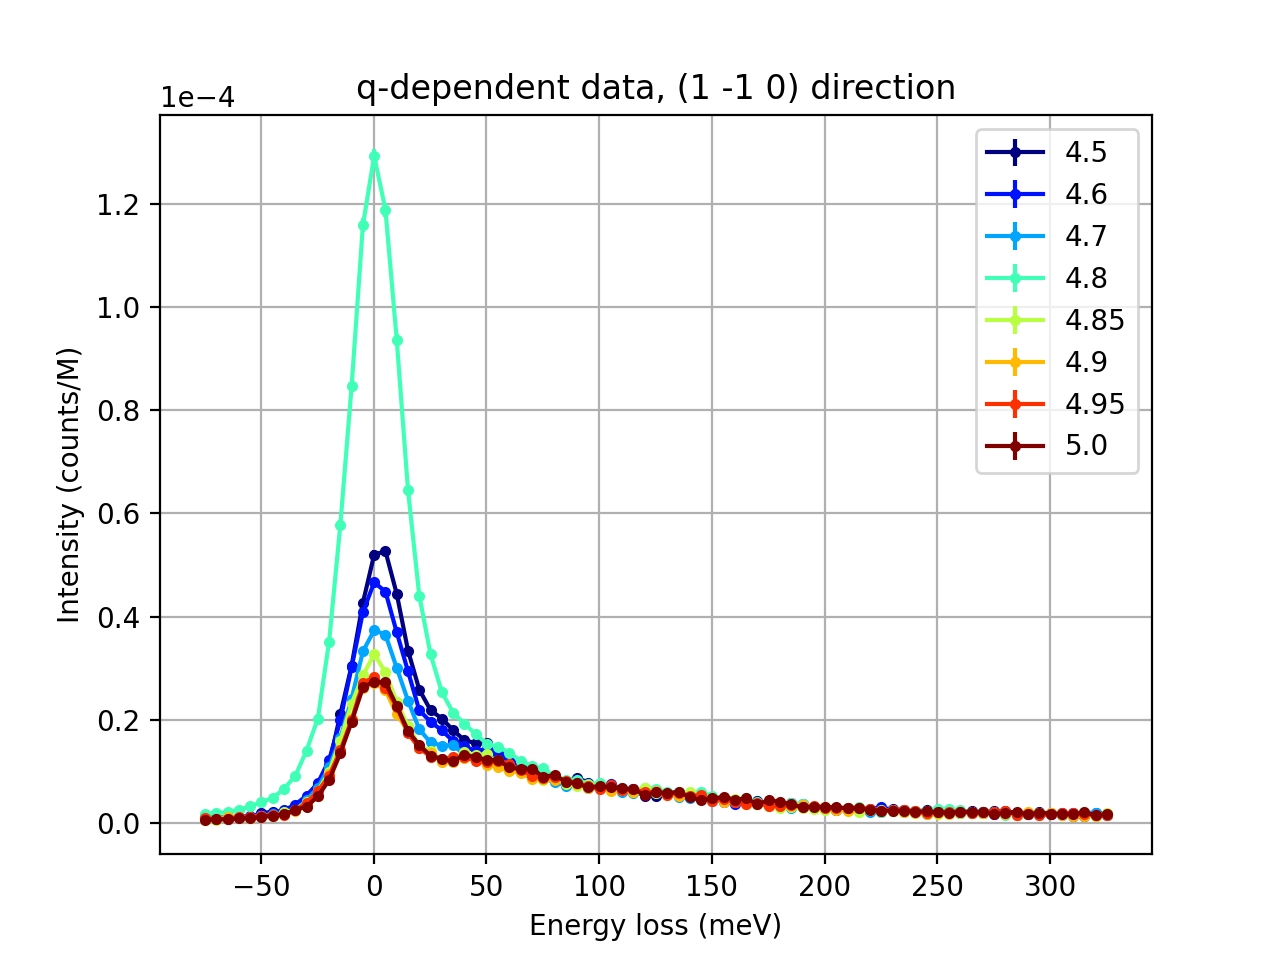

In [10]:
plt.figure()
colors = plt.cm.jet( np.linspace(0, 1, q_pts+1))
for i in range(q_pts+1):
    plt.errorbar(warmingdata[0], warmingdata[2*i+1], yerr=warmingdata[2*i+2], fmt='.-', color=colors[i])
    
plt.grid(True)
plt.xlabel('Energy loss (meV)')
plt.ylabel('Intensity (counts/M)')
plt.title('q-dependent data, (1 -1 0) direction')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().legend(['4.5', '4.6', '4.7', '4.8', '4.85', '4.9', '4.95', '5.0'])
#plt.yscale('log')
#plt.xlim(-50,200)
plt.show()

# Fitting

Here each q-point is fitted with a different set of initial parameters

In [11]:
#elastic (PseudoVoigt) + Three anti-Lor (2 magnon + continuum) + bg fit 
def Tdep(params, x, y):
    '''
    Magnon q-dep behavior for RIXS

    '''
    kB = 8.61733326e-2 # in meV/K
    T=10
    
    a0 = params['El_ratio']
    A0 = params['El_area']
    w0 = params['El_wid']
    x0 = params['El_pk']

    A1 = params['Pk1_area']
    x1 = params['Pk1_pk']
    w1 = params['Pk1_wid']
    
    A2 = params['Pk2_area']
    x2 = params['Pk2_pk']
    w2 = params['Pk2_wid']
    
    A3 = params['Pk3_area']
    x3 = params['Pk3_pk']
    w3 = params['Pk3_wid']
    
    bg = params['bg']
    
    sig0 = w0/(2*np.sqrt(2*np.log(2))) 
    elpk = a0*A0*np.exp(-(x-x0)**2/2/sig0**2)/sig0/np.sqrt(2*np.pi)+(1-a0)*A0*(w0/2)/np.pi/((x-x0)**2+(w0/2)**2) #pseudoVoigt
    
    antiLor1 = A1*1/(1-np.exp(-(x1-x0)/kB/T))*(w1/2)/np.pi/((x-(x1-x0))**2+(w1/2)**2)-A1*(w1/2)/np.pi/((x-x0+x1)**2+(w1/2)**2) #single magnon with bose factor
    aLor1 = np.where(antiLor1<0, 0, antiLor1)
    
    antiLor2 = A2*(w2/2)/np.pi/((x+x0-x2)**2+(w2/2)**2)-A2*(w2/2)/np.pi/((x-x0+x2)**2+(w2/2)**2) #continuum without bose factor
    aLor2 = np.where(antiLor2<0, 0., antiLor2)
    
    antiLor3 = A3*(w3/2)/np.pi/((x+x0-x3)**2+(w3/2)**2)-A3*(w3/2)/np.pi/((x-x0+x3)**2+(w3/2)**2) #continuum without bose factor
    aLor3 = np.where(antiLor3<0, 0., antiLor3)
    
    bg = bg
    model = elpk+aLor1+aLor2+aLor3+bg
    
    return model-y

def fit_qdep_5(x, y, plot_fit=False):
    # create a set of Parameters
    T=10
    params = Parameters()
    params.add('El_area', value=2e-3, min=0.)
    params.add('El_wid', value=28.0, min=25, max=30)
    params.add('El_pk', value=0, min=-3, max=3)
    params.add('El_ratio', value=0.58926547, vary=False)
    
    params.add('Pk1_area', value=1e-3, min=0.)
    params.add('Pk1_pk', value=35, min=25)
    params.add('Pk1_wid', value=40, min=15)
    
    params.add('Pk2_area', value=1e-3, min=0.)
    params.add('Pk2_pk', value=50, min=40)
    params.add('Pk2_wid', value=40, min=15)
    
    params.add('Pk3_area', value=0.0027, min=0.002, max=0.053)
    params.add('Pk3_pk', value=80, min=0., max=200)
    params.add('Pk3_wid', value=170, min=25, max=400)
    
    
    params.add('bg', value=1e-7, min=0, max=1e-6)
    
    # do fit, here with leastsq model
    
    minner = Minimizer(Tdep, params, fcn_args=(x, y))
    result = minner.minimize()

    # calculate final result
    final = y + result.residual

    # write error report
    report_fit(result)

    #define fitted peaks
    kB = 8.61733326e-2 # in meV/K
    sig0 = result.params['El_wid'].value/(2*np.sqrt(2*np.log(2))) 
    elpk = result.params['El_ratio'].value*result.params['El_area'].value*np.exp(-(x-result.params['El_pk'].value)**2/2/sig0**2)/sig0/np.sqrt(2*np.pi)+(1-result.params['El_ratio'].value)*result.params['El_area'].value*(result.params['El_wid'].value/2)/np.pi/((x-result.params['El_pk'].value)**2+(result.params['El_wid'].value/2)**2) #pseudoVoigt
    
    antiLor1 = result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x-(result.params['Pk1_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk1_wid'].value/2)**2)-result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x+result.params['Pk1_pk'].value-result.params['El_pk'].value)**2+(result.params['Pk1_wid'].value/2)**2) #single magnon with bose factor
    aLor1 = np.where(antiLor1<0, 0, antiLor1)
    
    antiLor2 = result.params['Pk2_area'].value*1/(1-np.exp(-(result.params['Pk2_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk2_wid'].value/2)/np.pi/((x-(result.params['Pk2_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk2_wid'].value/2)**2)-result.params['Pk2_area'].value*1/(1-np.exp(-(result.params['Pk2_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk2_wid'].value/2)/np.pi/((x+result.params['Pk2_pk'].value-result.params['El_pk'].value)**2+(result.params['Pk2_wid'].value/2)**2) #single magnon with bose factor
    aLor2 = np.where(antiLor2<0, 0, antiLor2)
    
    antiLor3 = result.params['Pk3_area'].value*(result.params['Pk3_wid'].value/2)/np.pi/((x-(result.params['Pk3_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk3_wid'].value/2)**2)-result.params['Pk3_area'].value*(result.params['Pk3_wid'].value/2)/np.pi/((x+(result.params['Pk3_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk3_wid'].value/2)**2) #continuum without bose factor
    aLor3 = np.where(antiLor3<0, 0., antiLor3)
    
    bg = result.params['bg'].value
    
    # write to csv
    
    df = pd.DataFrame({"eloss" : x, "elastic" : elpk+bg, "mag1" : aLor1+bg, "mag2" : aLor2+bg, "continuum" : aLor3+bg,
                      "total_model" : final, "total_data" : y, "residual" : result.residual})
    df.to_csv("YIO100nm_fit_0pt5.csv", index=False)
    
    # try to plot results
    try:
        if plot_fit:
            plt.figure()
            plt.plot(x, y, 'ko')
            plt.plot(x, final, 'r-')
            plt.plot(x, result.residual, 'g-')
            plt.plot(x, elpk+bg, 'b--')
            plt.plot(x, aLor1+bg, 'b--')
            plt.plot(x, aLor2+bg, 'b--')
            plt.plot(x, aLor3+bg, 'b--')
            plt.show()
    except ImportError:
        pass
    
    return final, result

## deltaq = 0.5

## deltaq = 0.4

In [13]:
def fit_qdep_4(x, y, plot_fit=False):
    # create a set of Parameters
    T=10
    params = Parameters()
    params.add('El_area', value=2e-3, min=0.)
    params.add('El_wid', value=28.0, min=25, max=30)
    params.add('El_pk', value=0, min=-3, max=3)
    params.add('El_ratio', value=0.58926547, vary=False)
    
    params.add('Pk1_area', value=1e-3, min=0.)
    params.add('Pk1_pk', value=35, min=25)
    params.add('Pk1_wid', value=40, min=15)
    
    params.add('Pk2_area', value=1e-3, min=0.)
    params.add('Pk2_pk', value=50, min=40)
    params.add('Pk2_wid', value=40, min=15)
    
    params.add('Pk3_area', value=0.0027, min=0.002, max=0.053)
    params.add('Pk3_pk', value=80, min=0., max=200)
    params.add('Pk3_wid', value=170, min=25, max=400)
    
    
    params.add('bg', value=1e-7, min=0, max=1e-6)
    
    # do fit, here with leastsq model
    
    minner = Minimizer(Tdep, params, fcn_args=(x, y))
    result = minner.minimize()

    # calculate final result
    final = y + result.residual

    # write error report
    report_fit(result)

    #define fitted peaks
    kB = 8.61733326e-2 # in meV/K
    sig0 = result.params['El_wid'].value/(2*np.sqrt(2*np.log(2))) 
    elpk = result.params['El_ratio'].value*result.params['El_area'].value*np.exp(-(x-result.params['El_pk'].value)**2/2/sig0**2)/sig0/np.sqrt(2*np.pi)+(1-result.params['El_ratio'].value)*result.params['El_area'].value*(result.params['El_wid'].value/2)/np.pi/((x-result.params['El_pk'].value)**2+(result.params['El_wid'].value/2)**2) #pseudoVoigt
    
    antiLor1 = result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x-(result.params['Pk1_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk1_wid'].value/2)**2)-result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x+result.params['Pk1_pk'].value-result.params['El_pk'].value)**2+(result.params['Pk1_wid'].value/2)**2) #single magnon with bose factor
    aLor1 = np.where(antiLor1<0, 0, antiLor1)
    
    antiLor2 = result.params['Pk2_area'].value*1/(1-np.exp(-(result.params['Pk2_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk2_wid'].value/2)/np.pi/((x-(result.params['Pk2_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk2_wid'].value/2)**2)-result.params['Pk2_area'].value*1/(1-np.exp(-(result.params['Pk2_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk2_wid'].value/2)/np.pi/((x+result.params['Pk2_pk'].value-result.params['El_pk'].value)**2+(result.params['Pk2_wid'].value/2)**2) #single magnon with bose factor
    aLor2 = np.where(antiLor2<0, 0, antiLor2)
    
    antiLor3 = result.params['Pk3_area'].value*(result.params['Pk3_wid'].value/2)/np.pi/((x-(result.params['Pk3_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk3_wid'].value/2)**2)-result.params['Pk3_area'].value*(result.params['Pk3_wid'].value/2)/np.pi/((x+(result.params['Pk3_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk3_wid'].value/2)**2) #continuum without bose factor
    aLor3 = np.where(antiLor3<0, 0., antiLor3)
    
    bg = result.params['bg'].value
    
    # write to csv
    
    df = pd.DataFrame({"eloss" : x, "elastic" : elpk+bg, "mag1" : aLor1+bg, "mag2" : aLor2+bg, "continuum" : aLor3+bg,
                      "total_model" : final, "total_data" : y, "residual" : result.residual})
    df.to_csv("YIO100nm_fit_0pt4.csv", index=False)
    
    # try to plot results
    try:
        if plot_fit:
            plt.figure()
            plt.plot(x, y, 'ko')
            plt.plot(x, final, 'r-')
            plt.plot(x, result.residual, 'g-')
            plt.plot(x, elpk+bg, 'b--')
            plt.plot(x, aLor1+bg, 'b--')
            plt.plot(x, aLor2+bg, 'b--')
            plt.plot(x, aLor3+bg, 'b--')
            plt.show()
    except ImportError:
        pass
    
    return final, result

## deltaq = 0.3

In [15]:
def fit_qdep_3(x, y, plot_fit=False):
    # create a set of Parameters
    T=10
    params = Parameters()
    params.add('El_area', value=2e-3, min=0.)
    params.add('El_wid', value=28.0, min=25, max=30)
    params.add('El_pk', value=0, min=-3, max=3)
    params.add('El_ratio', value=0.58926547, vary=False)
    
    params.add('Pk1_area', value=1e-3, min=1e-4)
    params.add('Pk1_pk', value=35, min=25)
    params.add('Pk1_wid', value=40, min=15)
    
    params.add('Pk2_area', value=5e-2, min=0.)
    params.add('Pk2_pk', value=50, min=35)
    params.add('Pk2_wid', value=40, min=15)
    
    params.add('Pk3_area', value=0.0027, min=0.002, max=0.053)
    params.add('Pk3_pk', value=80, min=0., max=200)
    params.add('Pk3_wid', value=170, min=25, max=400)
    
    
    params.add('bg', value=1e-7, min=0, max=1e-6)
    
    # do fit, here with leastsq model
    
    minner = Minimizer(Tdep, params, fcn_args=(x, y))
    result = minner.minimize()

    # calculate final result
    final = y + result.residual

    # write error report
    report_fit(result)

    #define fitted peaks
    kB = 8.61733326e-2 # in meV/K
    sig0 = result.params['El_wid'].value/(2*np.sqrt(2*np.log(2))) 
    elpk = result.params['El_ratio'].value*result.params['El_area'].value*np.exp(-(x-result.params['El_pk'].value)**2/2/sig0**2)/sig0/np.sqrt(2*np.pi)+(1-result.params['El_ratio'].value)*result.params['El_area'].value*(result.params['El_wid'].value/2)/np.pi/((x-result.params['El_pk'].value)**2+(result.params['El_wid'].value/2)**2) #pseudoVoigt
    
    antiLor1 = result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x-(result.params['Pk1_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk1_wid'].value/2)**2)-result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x+result.params['Pk1_pk'].value-result.params['El_pk'].value)**2+(result.params['Pk1_wid'].value/2)**2) #single magnon with bose factor
    aLor1 = np.where(antiLor1<0, 0, antiLor1)
    
    antiLor2 = result.params['Pk2_area'].value*1/(1-np.exp(-(result.params['Pk2_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk2_wid'].value/2)/np.pi/((x-(result.params['Pk2_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk2_wid'].value/2)**2)-result.params['Pk2_area'].value*1/(1-np.exp(-(result.params['Pk2_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk2_wid'].value/2)/np.pi/((x+result.params['Pk2_pk'].value-result.params['El_pk'].value)**2+(result.params['Pk2_wid'].value/2)**2) #single magnon with bose factor
    aLor2 = np.where(antiLor2<0, 0, antiLor2)
    
    antiLor3 = result.params['Pk3_area'].value*(result.params['Pk3_wid'].value/2)/np.pi/((x-(result.params['Pk3_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk3_wid'].value/2)**2)-result.params['Pk3_area'].value*(result.params['Pk3_wid'].value/2)/np.pi/((x+(result.params['Pk3_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk3_wid'].value/2)**2) #continuum without bose factor
    aLor3 = np.where(antiLor3<0, 0., antiLor3)
    
    bg = result.params['bg'].value
    
    # write to csv
    
    df = pd.DataFrame({"eloss" : x, "elastic" : elpk+bg, "mag1" : aLor1+bg, "mag2" : aLor2+bg, "continuum" : aLor3+bg,
                      "total_model" : final, "total_data" : y, "residual" : result.residual})
    df.to_csv("YIO100nm_fit_0pt3.csv", index=False)
    
    # try to plot results
    try:
        if plot_fit:
            plt.figure()
            plt.plot(x, y, 'ko')
            plt.plot(x, final, 'r-')
            plt.plot(x, result.residual, 'g-')
            plt.plot(x, elpk+bg, 'b--')
            plt.plot(x, aLor1+bg, 'b--')
            plt.plot(x, aLor2+bg, 'b--')
            plt.plot(x, aLor3+bg, 'b--')
            plt.show()
    except ImportError:
        pass
    
    return final, result

## deltaq = 0.15

In [17]:
def fit_qdep_15(x, y, plot_fit=False):
    # create a set of Parameters
    T=10
    params = Parameters()
    params.add('El_area', value=2e-3, min=0.)
    params.add('El_wid', value=28.0, min=25, max=30)
    params.add('El_pk', value=0, min=-3, max=3)
    params.add('El_ratio', value=0.58926547, vary=False)
    
    params.add('Pk1_area', value=1e-3, min=1e-5)
    params.add('Pk1_pk', value=22, min=20, max=35)
    params.add('Pk1_wid', value=20, min=15, max=40)
    
    params.add('Pk2_area', value=5e-2, min=0.)
    params.add('Pk2_pk', value=50, min=35, max=65)
    params.add('Pk2_wid', value=20, min=15, max=40)
    
    params.add('Pk3_area', value=0.0027, min=0.001, max=0.053)
    params.add('Pk3_pk', value=80, min=0., max=200)
    params.add('Pk3_wid', value=170, min=25, max=400)
    
    
    params.add('bg', value=1e-7, min=0, max=1e-6)
    
    # do fit, here with leastsq model
    
    minner = Minimizer(Tdep, params, fcn_args=(x, y))
    result = minner.minimize()

    # calculate final result
    final = y + result.residual

    # write error report
    report_fit(result)

    #define fitted peaks
    kB = 8.61733326e-2 # in meV/K
    sig0 = result.params['El_wid'].value/(2*np.sqrt(2*np.log(2))) 
    elpk = result.params['El_ratio'].value*result.params['El_area'].value*np.exp(-(x-result.params['El_pk'].value)**2/2/sig0**2)/sig0/np.sqrt(2*np.pi)+(1-result.params['El_ratio'].value)*result.params['El_area'].value*(result.params['El_wid'].value/2)/np.pi/((x-result.params['El_pk'].value)**2+(result.params['El_wid'].value/2)**2) #pseudoVoigt
    
    antiLor1 = result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x-(result.params['Pk1_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk1_wid'].value/2)**2)-result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x+result.params['Pk1_pk'].value-result.params['El_pk'].value)**2+(result.params['Pk1_wid'].value/2)**2) #single magnon with bose factor
    aLor1 = np.where(antiLor1<0, 0, antiLor1)
    
    antiLor2 = result.params['Pk2_area'].value*1/(1-np.exp(-(result.params['Pk2_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk2_wid'].value/2)/np.pi/((x-(result.params['Pk2_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk2_wid'].value/2)**2)-result.params['Pk2_area'].value*1/(1-np.exp(-(result.params['Pk2_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk2_wid'].value/2)/np.pi/((x+result.params['Pk2_pk'].value-result.params['El_pk'].value)**2+(result.params['Pk2_wid'].value/2)**2) #single magnon with bose factor
    aLor2 = np.where(antiLor2<0, 0, antiLor2)
    
    antiLor3 = result.params['Pk3_area'].value*(result.params['Pk3_wid'].value/2)/np.pi/((x-(result.params['Pk3_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk3_wid'].value/2)**2)-result.params['Pk3_area'].value*(result.params['Pk3_wid'].value/2)/np.pi/((x+(result.params['Pk3_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk3_wid'].value/2)**2) #continuum without bose factor
    aLor3 = np.where(antiLor3<0, 0., antiLor3)
    
    bg = result.params['bg'].value
    
    # write to csv
    
    df = pd.DataFrame({"eloss" : x, "elastic" : elpk+bg, "mag1" : aLor1+bg, "mag2" : aLor2+bg, "continuum" : aLor3+bg,
                      "total_model" : final, "total_data" : y, "residual" : result.residual})
    df.to_csv("YIO100nm_fit_0pt15.csv", index=False)
    
    # try to plot results
    try:
        if plot_fit:
            plt.figure()
            plt.plot(x, y, 'ko')
            plt.plot(x, final, 'r-')
            plt.plot(x, result.residual, 'g-')
            plt.plot(x, elpk+bg, 'b--')
            plt.plot(x, aLor1+bg, 'b--')
            plt.plot(x, aLor2+bg, 'b--')
            plt.plot(x, aLor3+bg, 'b--')
            plt.show()
    except ImportError:
        pass
    
    return final, result

## deltaq = 0.1

In [19]:
def fit_qdep_1(x, y, plot_fit=False):
    # create a set of Parameters
    T=10
    params = Parameters()
    params.add('El_area', value=2e-3, min=0.)
    params.add('El_wid', value=28.0, min=25, max=30)
    params.add('El_pk', value=0, min=-3, max=3)
    params.add('El_ratio', value=0.58926547, vary=False)
    
    params.add('Pk1_area', value=1e-3, min=1e-5)
    params.add('Pk1_pk', value=22, min=20, max=35)
    params.add('Pk1_wid', value=20, min=15, max=40)
    
    params.add('Pk2_area', value=5e-2, min=0.)
    params.add('Pk2_pk', value=50, min=35, max=65)
    params.add('Pk2_wid', value=20, min=15, max=40)
    
    params.add('Pk3_area', value=0.0027, min=0.001, max=0.053)
    params.add('Pk3_pk', value=80, min=0., max=200)
    params.add('Pk3_wid', value=170, min=25, max=400)
    
    
    params.add('bg', value=1e-7, min=0, max=1e-6)
    
    # do fit, here with leastsq model
    
    minner = Minimizer(Tdep, params, fcn_args=(x, y))
    result = minner.minimize()

    # calculate final result
    final = y + result.residual

    # write error report
    report_fit(result)

    #define fitted peaks
    kB = 8.61733326e-2 # in meV/K
    sig0 = result.params['El_wid'].value/(2*np.sqrt(2*np.log(2))) 
    elpk = result.params['El_ratio'].value*result.params['El_area'].value*np.exp(-(x-result.params['El_pk'].value)**2/2/sig0**2)/sig0/np.sqrt(2*np.pi)+(1-result.params['El_ratio'].value)*result.params['El_area'].value*(result.params['El_wid'].value/2)/np.pi/((x-result.params['El_pk'].value)**2+(result.params['El_wid'].value/2)**2) #pseudoVoigt
    
    antiLor1 = result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x-(result.params['Pk1_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk1_wid'].value/2)**2)-result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x+result.params['Pk1_pk'].value-result.params['El_pk'].value)**2+(result.params['Pk1_wid'].value/2)**2) #single magnon with bose factor
    aLor1 = np.where(antiLor1<0, 0, antiLor1)
    
    antiLor2 = result.params['Pk2_area'].value*1/(1-np.exp(-(result.params['Pk2_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk2_wid'].value/2)/np.pi/((x-(result.params['Pk2_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk2_wid'].value/2)**2)-result.params['Pk2_area'].value*1/(1-np.exp(-(result.params['Pk2_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk2_wid'].value/2)/np.pi/((x+result.params['Pk2_pk'].value-result.params['El_pk'].value)**2+(result.params['Pk2_wid'].value/2)**2) #single magnon with bose factor
    aLor2 = np.where(antiLor2<0, 0, antiLor2)
    
    antiLor3 = result.params['Pk3_area'].value*(result.params['Pk3_wid'].value/2)/np.pi/((x-(result.params['Pk3_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk3_wid'].value/2)**2)-result.params['Pk3_area'].value*(result.params['Pk3_wid'].value/2)/np.pi/((x+(result.params['Pk3_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk3_wid'].value/2)**2) #continuum without bose factor
    aLor3 = np.where(antiLor3<0, 0., antiLor3)
    
    bg = result.params['bg'].value
    
    # write to csv
    
    df = pd.DataFrame({"eloss" : x, "elastic" : elpk+bg, "mag1" : aLor1+bg, "mag2" : aLor2+bg, "continuum" : aLor3+bg,
                      "total_model" : final, "total_data" : y, "residual" : result.residual})
    df.to_csv("YIO100nm_fit_0pt1.csv", index=False)
    
    # try to plot results
    try:
        if plot_fit:
            plt.figure()
            plt.plot(x, y, 'ko')
            plt.plot(x, final, 'r-')
            plt.plot(x, result.residual, 'g-')
            plt.plot(x, elpk+bg, 'b--')
            plt.plot(x, aLor1+bg, 'b--')
            plt.plot(x, aLor2+bg, 'b--')
            plt.plot(x, aLor3+bg, 'b--')
            plt.show()
    except ImportError:
        pass
    
    return final, result

## deltaq = 0 (Gamma)

In [62]:
def fit_qdep_0(x, y, plot_fit=False):
    # create a set of Parameters
    T=10
    params = Parameters()
    params.add('El_area', value=2e-3, min=0.)
    params.add('El_wid', value=28.0, min=25, max=30)
    params.add('El_pk', value=0, min=-3, max=3)
    params.add('El_ratio', value=0.58926547, vary=False)
    
    params.add('Pk1_area', value=1e-3, min=1e-5)
    params.add('Pk1_pk', value=22, min=20, max=35)
    params.add('Pk1_wid', value=20, min=15, max=40)
    
    params.add('Pk2_area', value=5e-2, min=0.)
    params.add('Pk2_pk', value=50, min=35, max=65)
    params.add('Pk2_wid', value=20, min=15, max=40)
    
    params.add('Pk3_area', value=0.0027, min=0.001, max=0.053)
    params.add('Pk3_pk', value=80, min=0., max=200)
    params.add('Pk3_wid', value=170, min=25, max=400)
    
    
    params.add('bg', value=1e-7, min=0, max=1e-6)
    
    # do fit, here with leastsq model
    
    minner = Minimizer(Tdep, params, fcn_args=(x, y))
    result = minner.minimize()

    # calculate final result
    final = y + result.residual

    # write error report
    report_fit(result)

    #define fitted peaks
    kB = 8.61733326e-2 # in meV/K
    sig0 = result.params['El_wid'].value/(2*np.sqrt(2*np.log(2))) 
    elpk = result.params['El_ratio'].value*result.params['El_area'].value*np.exp(-(x-result.params['El_pk'].value)**2/2/sig0**2)/sig0/np.sqrt(2*np.pi)+(1-result.params['El_ratio'].value)*result.params['El_area'].value*(result.params['El_wid'].value/2)/np.pi/((x-result.params['El_pk'].value)**2+(result.params['El_wid'].value/2)**2) #pseudoVoigt
    
    antiLor1 = result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x-(result.params['Pk1_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk1_wid'].value/2)**2)-result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x+result.params['Pk1_pk'].value-result.params['El_pk'].value)**2+(result.params['Pk1_wid'].value/2)**2) #single magnon with bose factor
    aLor1 = np.where(antiLor1<0, 0, antiLor1)
    
    antiLor2 = result.params['Pk2_area'].value*1/(1-np.exp(-(result.params['Pk2_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk2_wid'].value/2)/np.pi/((x-(result.params['Pk2_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk2_wid'].value/2)**2)-result.params['Pk2_area'].value*1/(1-np.exp(-(result.params['Pk2_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk2_wid'].value/2)/np.pi/((x+result.params['Pk2_pk'].value-result.params['El_pk'].value)**2+(result.params['Pk2_wid'].value/2)**2) #single magnon with bose factor
    aLor2 = np.where(antiLor2<0, 0, antiLor2)
    
    antiLor3 = result.params['Pk3_area'].value*(result.params['Pk3_wid'].value/2)/np.pi/((x-(result.params['Pk3_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk3_wid'].value/2)**2)-result.params['Pk3_area'].value*(result.params['Pk3_wid'].value/2)/np.pi/((x+(result.params['Pk3_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk3_wid'].value/2)**2) #continuum without bose factor
    aLor3 = np.where(antiLor3<0, 0., antiLor3)
    
    bg = result.params['bg'].value
    
    # write to csv
    
    df = pd.DataFrame({"eloss" : x, "elastic" : elpk+bg, "mag1" : aLor1+bg, "mag2" : aLor2+bg, "continuum" : aLor3+bg,
                      "total_model" : final, "total_data" : y, "residual" : result.residual})
    df.to_csv("YIO100nm_fit_0.csv", index=False)
    
    # try to plot results
    try:
        if plot_fit:
            plt.figure()
            plt.plot(x, y, 'ko')
            plt.plot(x, final, 'r-')
            plt.plot(x, result.residual, 'g-')
            plt.plot(x, elpk+bg, 'b--')
            plt.plot(x, aLor1+bg, 'b--')
            plt.plot(x, aLor2+bg, 'b--')
            plt.plot(x, aLor3+bg, 'b--')
            plt.show()
    except ImportError:
        pass
    
    return final, result

# Batch fitting

In [49]:
T = np.array([0.5, 0.4, 0.3, 0.2, 0.15, 0.1, 0.05, 0]) #remember to ignore 0.2 - elastic line dominates

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2029
    # data points      = 81
    # variables        = 13
    chi-square         = 9.2468e-12
    reduced chi-square = 1.3598e-13
    Akaike info crit   = -2387.89676
    Bayesian info crit = -2356.76892
[[Variables]]
    El_area:   0.00177540 +/- 2.0095e-05 (1.13%) (init = 0.002)
    El_wid:    28.0021344 +/- 0.29082774 (1.04%) (init = 28)
    El_pk:     2.30723753 +/- 0.14331857 (6.21%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  2.2668e-04 +/- 5.6005e-05 (24.71%) (init = 0.001)
    Pk1_pk:    32.8595100 +/- 0.68355941 (2.08%) (init = 35)
    Pk1_wid:   18.3800370 +/- 3.01749348 (16.42%) (init = 40)
    Pk2_area:  2.3639e-04 +/- 1.1027e-04 (46.65%) (init = 0.001)
    Pk2_pk:    51.9095689 +/- 1.41583816 (2.73%) (init = 50)
    Pk2_wid:   26.3054094 +/- 6.64060116 (25.24%) (init = 40)
    Pk3_area:  0.05273698 +/- 5.38674219 (10214.35%) (init = 0.0027)
    Pk3_pk:    6.31462582 +/- 421.79805

<IPython.core.display.Javascript object>


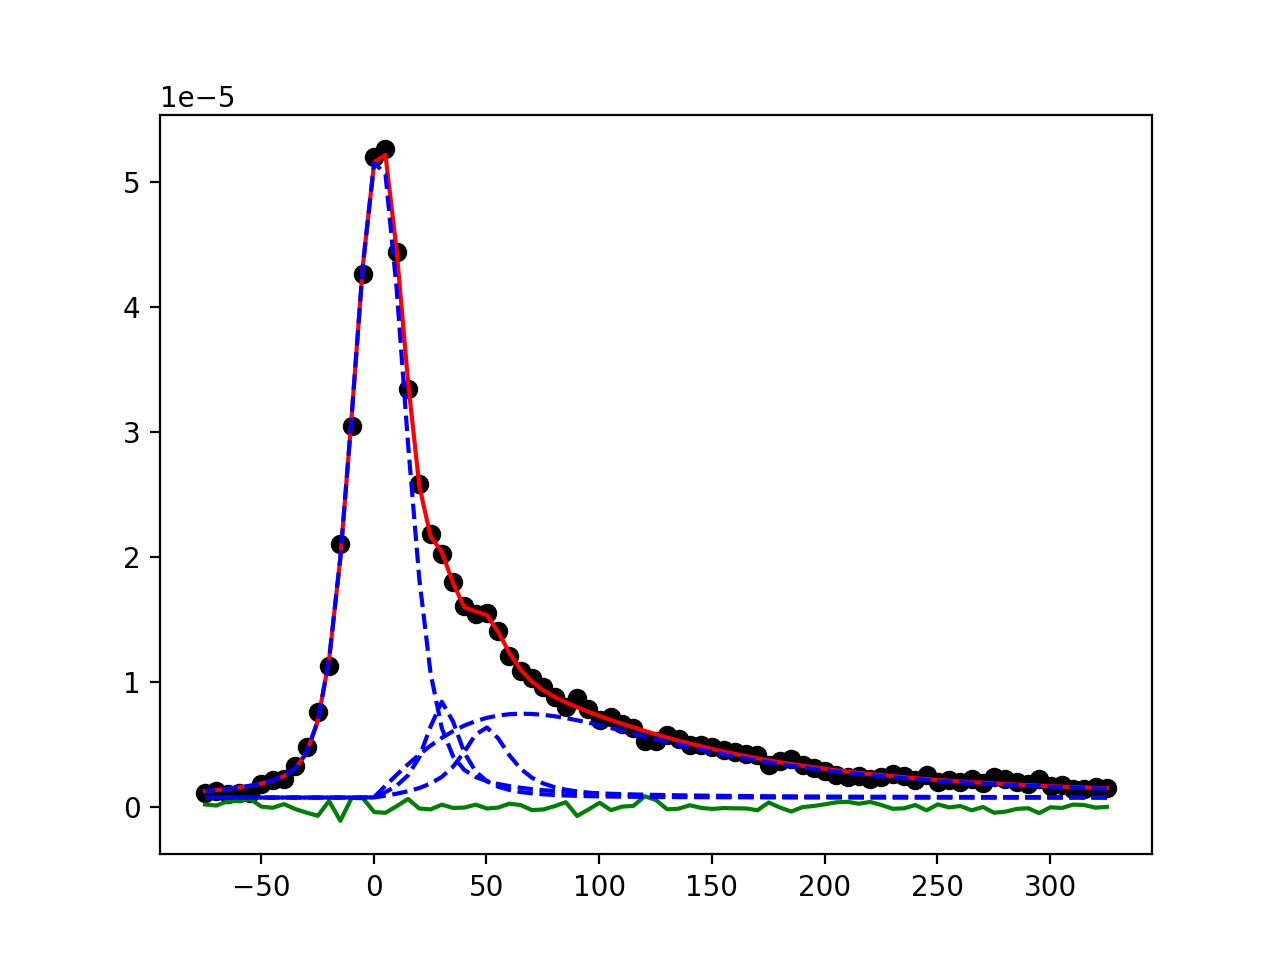

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 142
    # data points      = 81
    # variables        = 13
    chi-square         = 6.7959e-12
    reduced chi-square = 9.9939e-14
    Akaike info crit   = -2412.84152
    Bayesian info crit = -2381.71368
[[Variables]]
    El_area:   0.00158802 +/- 1.7334e-05 (1.09%) (init = 0.002)
    El_wid:    28.4041875 +/- 0.29544656 (1.04%) (init = 28)
    El_pk:     1.13587078 +/- 0.13262951 (11.68%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  2.3904e-04 +/- 6.2852e-05 (26.29%) (init = 0.001)
    Pk1_pk:    30.6426539 +/- 0.77322559 (2.52%) (init = 35)
    Pk1_wid:   21.3007385 +/- 3.64031992 (17.09%) (init = 40)
    Pk2_area:  2.8138e-04 +/- 1.4442e-04 (51.33%) (init = 0.001)
    Pk2_pk:    52.0466457 +/- 1.81785424 (3.49%) (init = 50)
    Pk2_wid:   32.9962855 +/- 8.45657645 (25.63%) (init = 40)
    Pk3_area:  0.00490389 +/- 0.00521271 (106.30%) (init = 0.0027)
    Pk3_pk:    42.7452613 +/- 39.9666476 

<IPython.core.display.Javascript object>


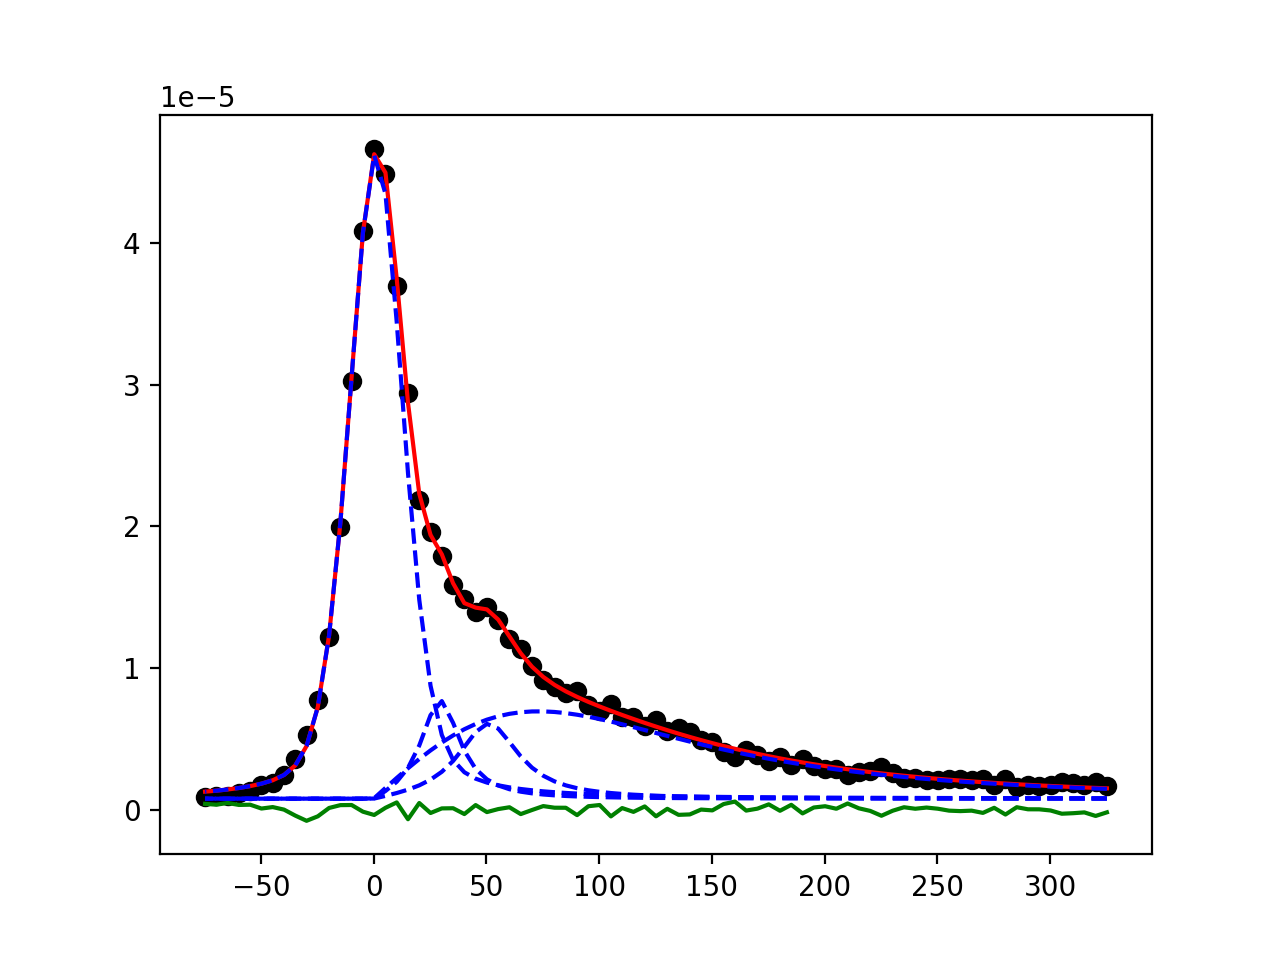

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 430
    # data points      = 81
    # variables        = 13
    chi-square         = 6.3479e-12
    reduced chi-square = 9.3351e-14
    Akaike info crit   = -2418.36514
    Bayesian info crit = -2387.23730
[[Variables]]
    El_area:   0.00131161 +/- 1.5194e-05 (1.16%) (init = 0.002)
    El_wid:    29.2078044 +/- 0.32784294 (1.12%) (init = 28)
    El_pk:     1.23843477 +/- 0.14442185 (11.66%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  1.9987e-04 +/- 5.2338e-05 (26.19%) (init = 0.001)
    Pk1_pk:    34.2931590 +/- 0.78587376 (2.29%) (init = 35)
    Pk1_wid:   20.2283500 +/- 3.52430288 (17.42%) (init = 40)
    Pk2_area:  2.1804e-04 +/- 1.0809e-04 (49.57%) (init = 0.05)
    Pk2_pk:    54.3172650 +/- 1.86072017 (3.43%) (init = 50)
    Pk2_wid:   30.2283998 +/- 7.97770052 (26.39%) (init = 40)
    Pk3_area:  0.00611015 +/- 0.00937431 (153.42%) (init = 0.0027)
    Pk3_pk:    35.8387773 +/- 49.8600848 (

<IPython.core.display.Javascript object>


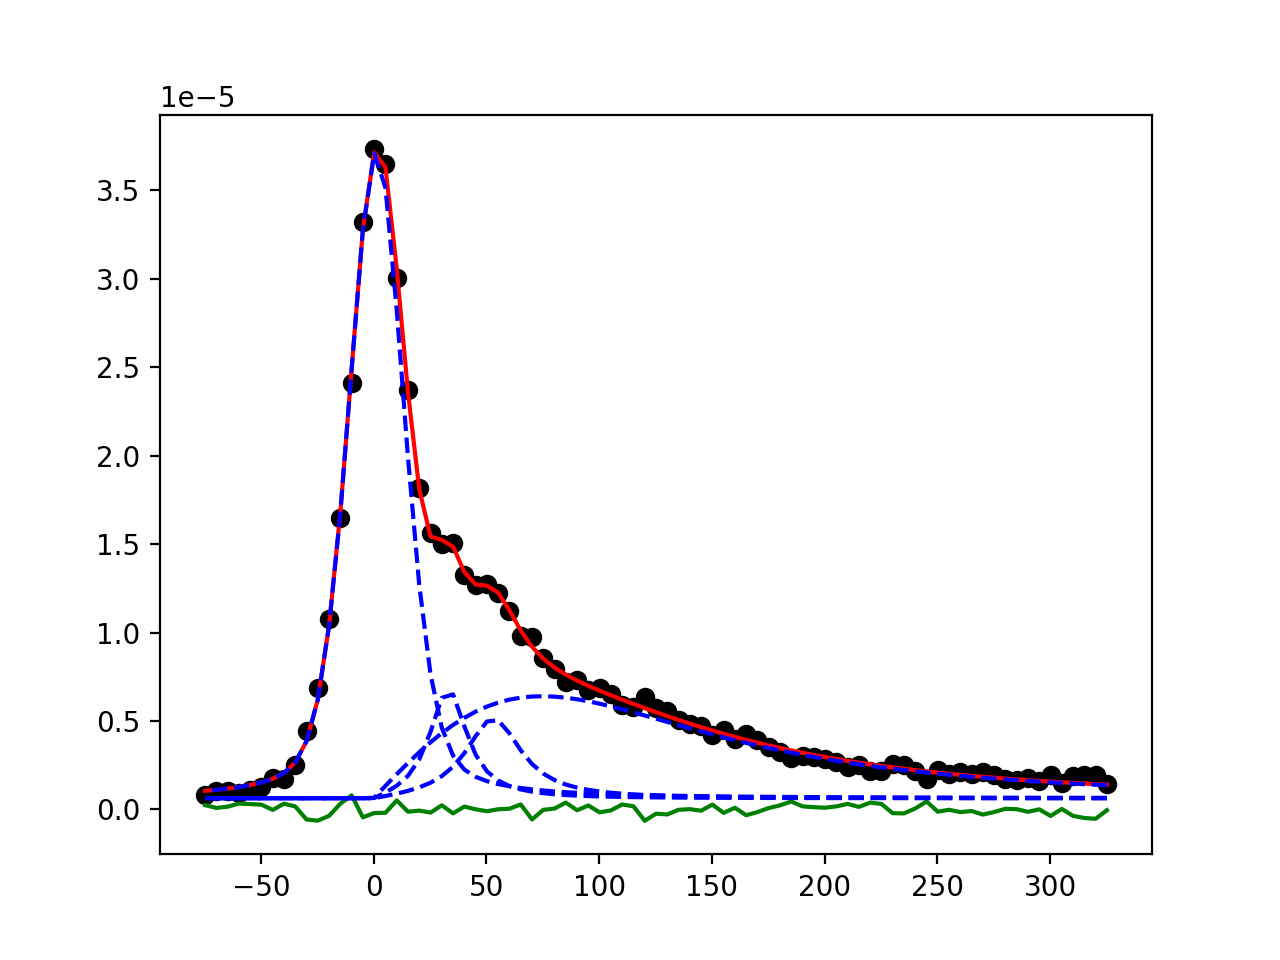

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4771
    # data points      = 81
    # variables        = 13
    chi-square         = 9.5298e-12
    reduced chi-square = 1.4014e-13
    Akaike info crit   = -2385.45480
    Bayesian info crit = -2354.32696
[[Variables]]
    El_area:   0.00107885 +/- 1.8025e-05 (1.67%) (init = 0.002)
    El_wid:    28.3782179 +/- 0.48072732 (1.69%) (init = 28)
    El_pk:    -0.34377531 +/- 0.18571960 (54.02%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  6.2877e-05 +/- 5.0459e-05 (80.25%) (init = 0.001)
    Pk1_pk:    23.7503160 +/- 1.67019287 (7.03%) (init = 22)
    Pk1_wid:   15.0000001 +/- 0.78265845 (5.22%) (init = 20)
    Pk2_area:  4.4002e-04 +/- 1.5788e-04 (35.88%) (init = 0.05)
    Pk2_pk:    43.8093281 +/- 1.59817279 (3.65%) (init = 50)
    Pk2_wid:   36.3295273 +/- 7.38518984 (20.33%) (init = 20)
    Pk3_area:  0.00276095 +/- 0.00110474 (40.01%) (init = 0.0027)
    Pk3_pk:    68.3924169 +/- 19.8942062 (2

<IPython.core.display.Javascript object>


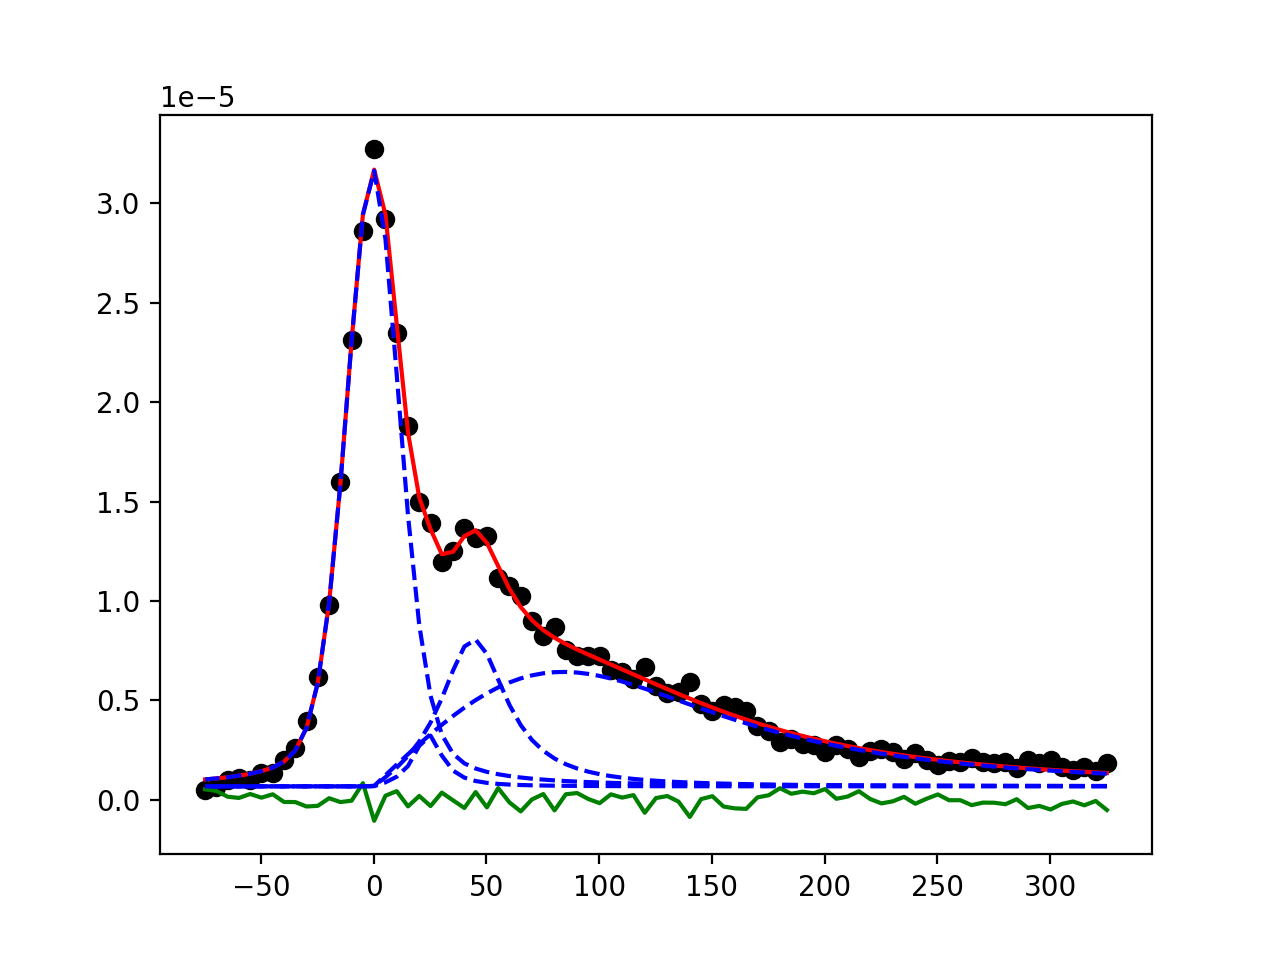

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1208
    # data points      = 81
    # variables        = 13
    chi-square         = 4.8274e-12
    reduced chi-square = 7.0991e-14
    Akaike info crit   = -2440.54464
    Bayesian info crit = -2409.41680
[[Variables]]
    El_area:   9.2741e-04 +/- 1.8945e-05 (2.04%) (init = 0.002)
    El_wid:    28.2977536 +/- 0.53094052 (1.88%) (init = 28)
    El_pk:    -0.75253116 +/- 0.23873520 (31.72%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  1.0515e-04 +/- 6.3715e-05 (60.60%) (init = 0.001)
    Pk1_pk:    20.9987469 +/- 1.61592556 (7.70%) (init = 22)
    Pk1_wid:   20.7306370 +/- 7.44641306 (35.92%) (init = 20)
    Pk2_area:  2.6198e-04 +/- 1.4056e-04 (53.65%) (init = 0.05)
    Pk2_pk:    42.1673300 +/- 1.90745855 (4.52%) (init = 50)
    Pk2_wid:   34.4364762 +/- 9.04266882 (26.26%) (init = 20)
    Pk3_area:  0.05299862 +/- 3.94440916 (7442.48%) (init = 0.0027)
    Pk3_pk:    3.34724055 +/- 341.800536

<IPython.core.display.Javascript object>


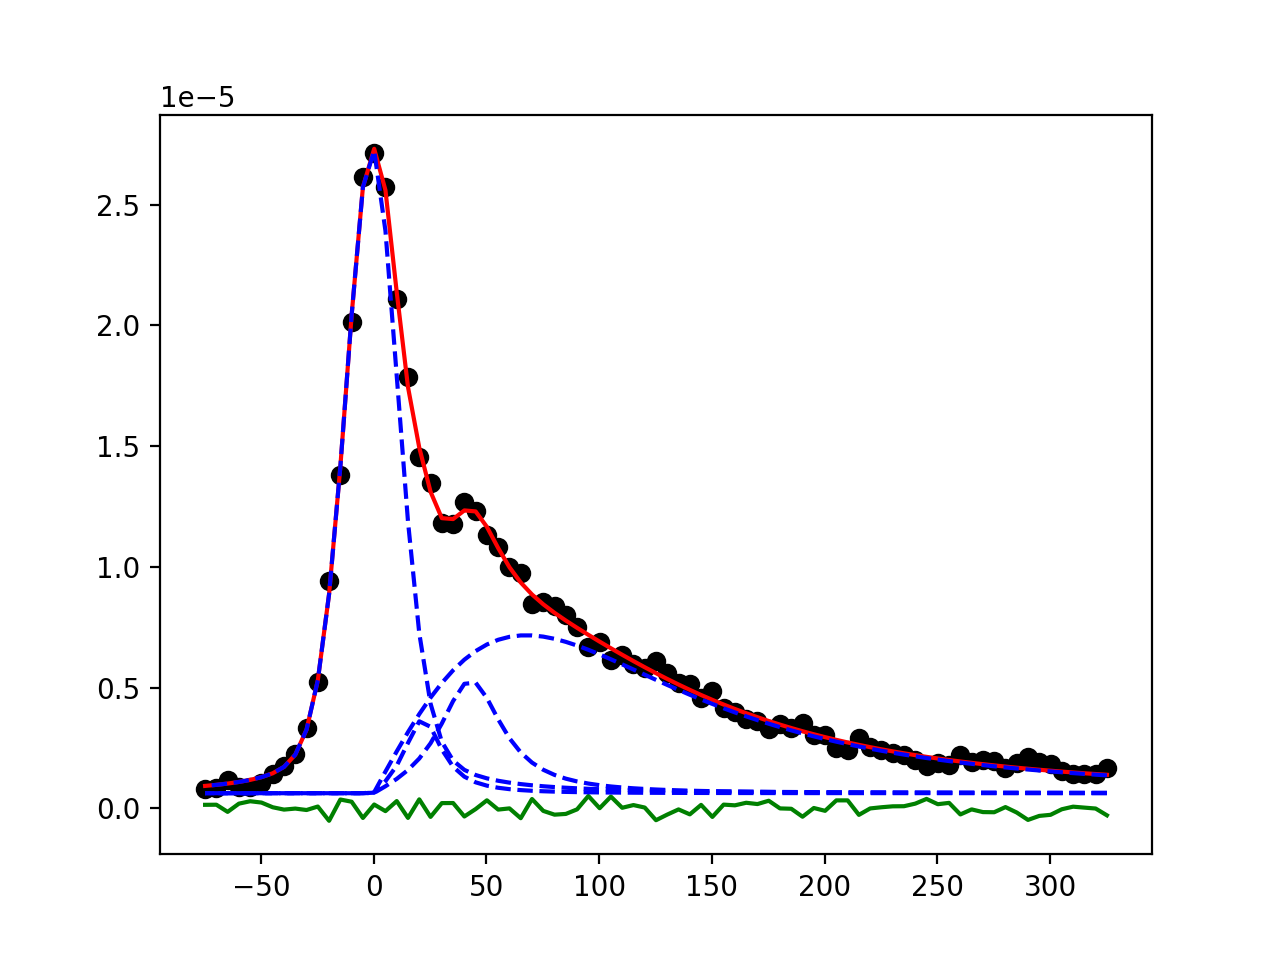

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17651
    # data points      = 81
    # variables        = 13
    chi-square         = 7.8395e-12
    reduced chi-square = 1.1529e-13
    Akaike info crit   = -2401.26986
    Bayesian info crit = -2370.14202
[[Variables]]
    El_area:   9.3985e-04 +/- 3.3978e-05 (3.62%) (init = 0.002)
    El_wid:    28.0487018 +/- 0.83533158 (2.98%) (init = 28)
    El_pk:    -0.16857567 +/- 0.43730121 (259.41%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  2.2417e-04 +/- 3.9826e-04 (177.66%) (init = 0.001)
    Pk1_pk:    23.0049172 +/- 7.05911858 (30.69%) (init = 22)
    Pk1_wid:   39.9999999 +/- 35.1275581 (87.82%) (init = 20)
    Pk2_area:  3.0763e-04 +/- 3.4836e-04 (113.24%) (init = 0.05)
    Pk2_pk:    47.0642649 +/- 4.97871869 (10.58%) (init = 50)
    Pk2_wid:   39.9995721 +/- 16.9954282 (42.49%) (init = 20)
    Pk3_area:  0.05180353 +/- 5.88628986 (11362.72%) (init = 0.0027)
    Pk3_pk:    4.45893959 +/- 525

<IPython.core.display.Javascript object>


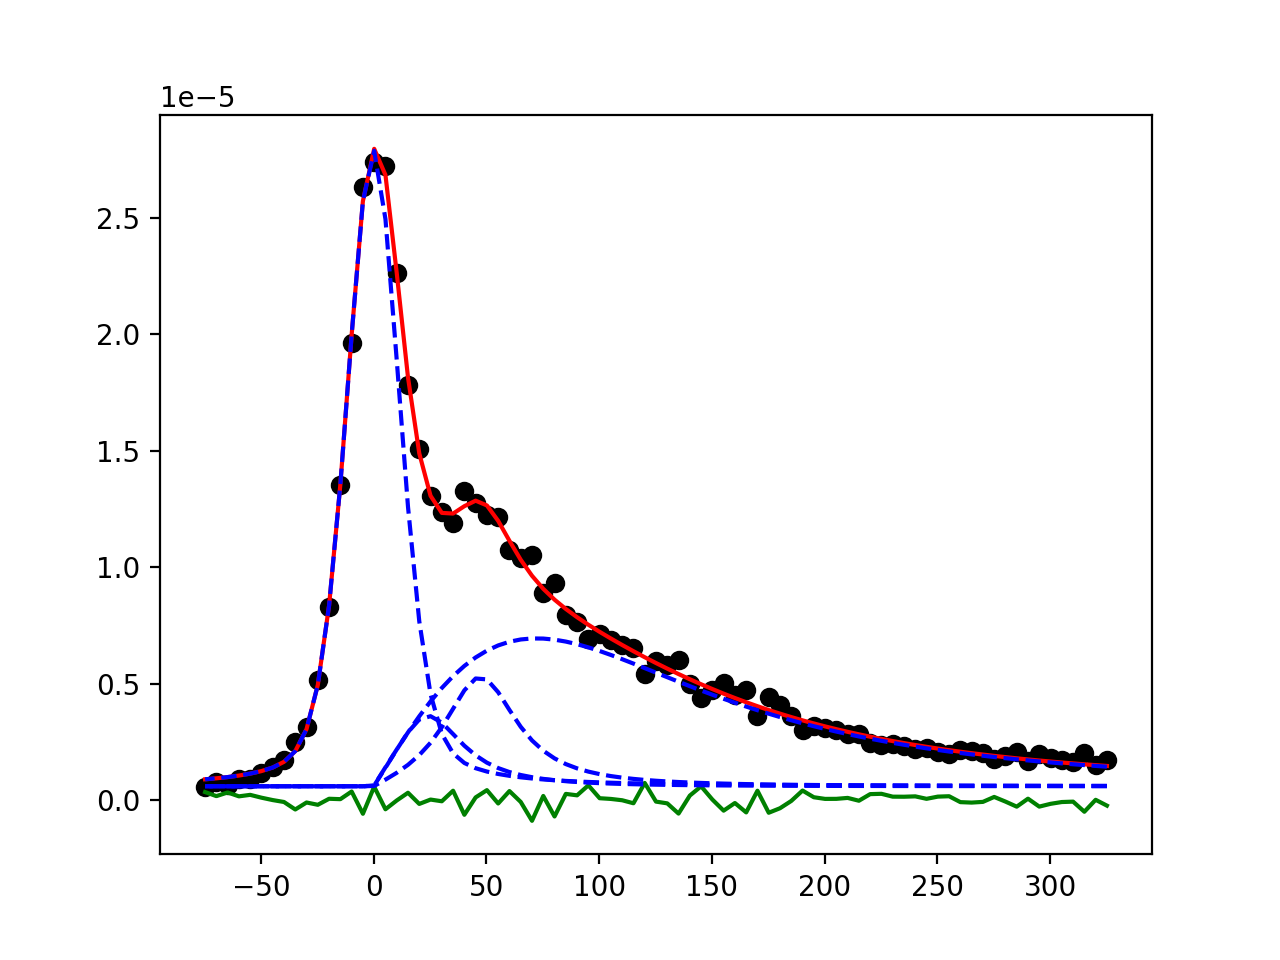

In [55]:
elpks = []
elpks_err = []
elpkwids = []
elpkwids_err = []
elpkAreas = []
elpkAreas_err = []

magpks_ALor = []
magpks_ALor_err = []
magpkwids_ALor = []
magpkwids_ALor_err = []
magpkAreas_ALor = []
magpkAreas_ALor_err = []

mag2pks_ALor = []
mag2pks_ALor_err = []
mag2pkwids_ALor = []
mag2pkwids_ALor_err = []
mag2pkAreas_ALor = []
mag2pkAreas_ALor_err = []

conpks_ALor = []
conpks_ALor_err = []
conpkwids_ALor = []
conpkwids_ALor_err = []
conpkAreas_ALor = []
conpkAreas_ALor_err = []

'''
a0 = params['El_ratio']
    A0 = params['El_area']
    w0 = params['El_wid']
    x0 = params['El_pk']

    A1 = params['Pk1_area']
    x1 = params['Pk1_pk']
    w1 = params['Pk1_wid']
    
    A2 = params['Pk2_area']
    x2 = params['Pk2_pk']
    w2 = params['Pk2_wid']
    
    bg = params['bg']
'''

for i in np.arange(8):
    
    if i == 0:
        final, result = fit_qdep_5(warmingdata[0, :], warmingdata[1, :], plot_fit=True)
    if i == 1:
        final, result = fit_qdep_4(warmingdata[0, :], warmingdata[3, :], plot_fit=True)
    if i == 2:
        final, result = fit_qdep_3(warmingdata[0, :], warmingdata[5, :], plot_fit=True)
    if i == 3: #0.2
        continue
    if i == 4:
        final, result = fit_qdep_15(warmingdata[0, :], warmingdata[9, :], plot_fit=True)
    if i == 5:
        final, result = fit_qdep_1(warmingdata[0, :], warmingdata[11, :], plot_fit=True)
    if i == 6:
        continue
    if i == 7:
        final, result = fit_qdep_1(warmingdata[0, :], warmingdata[15, :], plot_fit=True)
    
    elpks.append(result.params['El_pk'].value)
    elpks_err.append(result.params['El_pk'].stderr)
    
    elpkwids.append(result.params['El_wid'].value)
    elpkwids_err.append(result.params['El_wid'].stderr)
    
    elpkAreas.append(result.params['El_area'].value)
    elpkAreas_err.append(result.params['El_area'].stderr)
    
    
    magpks_ALor.append(result.params['Pk1_pk'].value)
    magpks_ALor_err.append(result.params['Pk2_pk'].stderr)
    
    magpkwids_ALor.append(result.params['Pk1_wid'].value)
    magpkwids_ALor_err.append(result.params['Pk1_wid'].stderr)
    
    magpkAreas_ALor.append(result.params['Pk1_area'].value)
    magpkAreas_ALor_err.append(result.params['Pk1_area'].stderr)
    
    mag2pks_ALor.append(result.params['Pk2_pk'].value)
    mag2pks_ALor_err.append(result.params['Pk2_pk'].stderr)
    
    mag2pkwids_ALor.append(result.params['Pk2_wid'].value)
    mag2pkwids_ALor_err.append(result.params['Pk2_wid'].stderr)
    
    mag2pkAreas_ALor.append(result.params['Pk2_area'].value)
    mag2pkAreas_ALor_err.append(result.params['Pk2_area'].stderr)

    
    conpks_ALor.append(result.params['Pk3_pk'].value)
    conpks_ALor_err.append(result.params['Pk3_pk'].stderr)
    
    conpkwids_ALor.append(result.params['Pk3_wid'].value)
    conpkwids_ALor_err.append(result.params['Pk3_wid'].stderr)
    
    conpkAreas_ALor.append(result.params['Pk3_area'].value)
    conpkAreas_ALor_err.append(result.params['Pk3_area'].stderr)

       
elpks = np.array(elpks)
elpks_err = np.array(elpks_err)
elpkwids_ALor = np.array(elpkwids) #delete ALor
elpkwids_ALor_err = np.array(elpkwids_err) #delete ALor
elpkAreas_ALor = np.array(elpkAreas) #delete ALor
elpkAreas_ALor_err = np.array(elpkAreas_err) #delete ALor

magpks_ALor = np.array(magpks_ALor)
magpks_ALor_err = np.array(magpks_ALor_err)
magpkwids_ALor = np.array(magpkwids_ALor)
magpkwids_ALor_err = np.array(magpkwids_ALor_err)
magpkAreas_ALor = np.array(magpkAreas_ALor)
magpkAreas_ALor_err = np.array(magpkAreas_ALor_err)

mag2pks_ALor = np.array(mag2pks_ALor)
mag2pks_ALor_err = np.array(mag2pks_ALor_err)
mag2pkwids_ALor = np.array(mag2pkwids_ALor)
mag2pkwids_ALor_err = np.array(mag2pkwids_ALor_err)
mag2pkAreas_ALor = np.array(mag2pkAreas_ALor)
mag2pkAreas_ALor_err = np.array(mag2pkAreas_ALor_err)

conpks_ALor = np.array(conpks_ALor)
conpks_ALor_err = np.array(conpks_ALor_err)
conpkwids_ALor = np.array(conpkwids_ALor)
conpkwids_ALor_err = np.array(conpkwids_ALor_err)
conpkAreas_ALor = np.array(conpkAreas_ALor)
conpkAreas_ALor_err = np.array(conpkAreas_ALor_err)

<IPython.core.display.Javascript object>


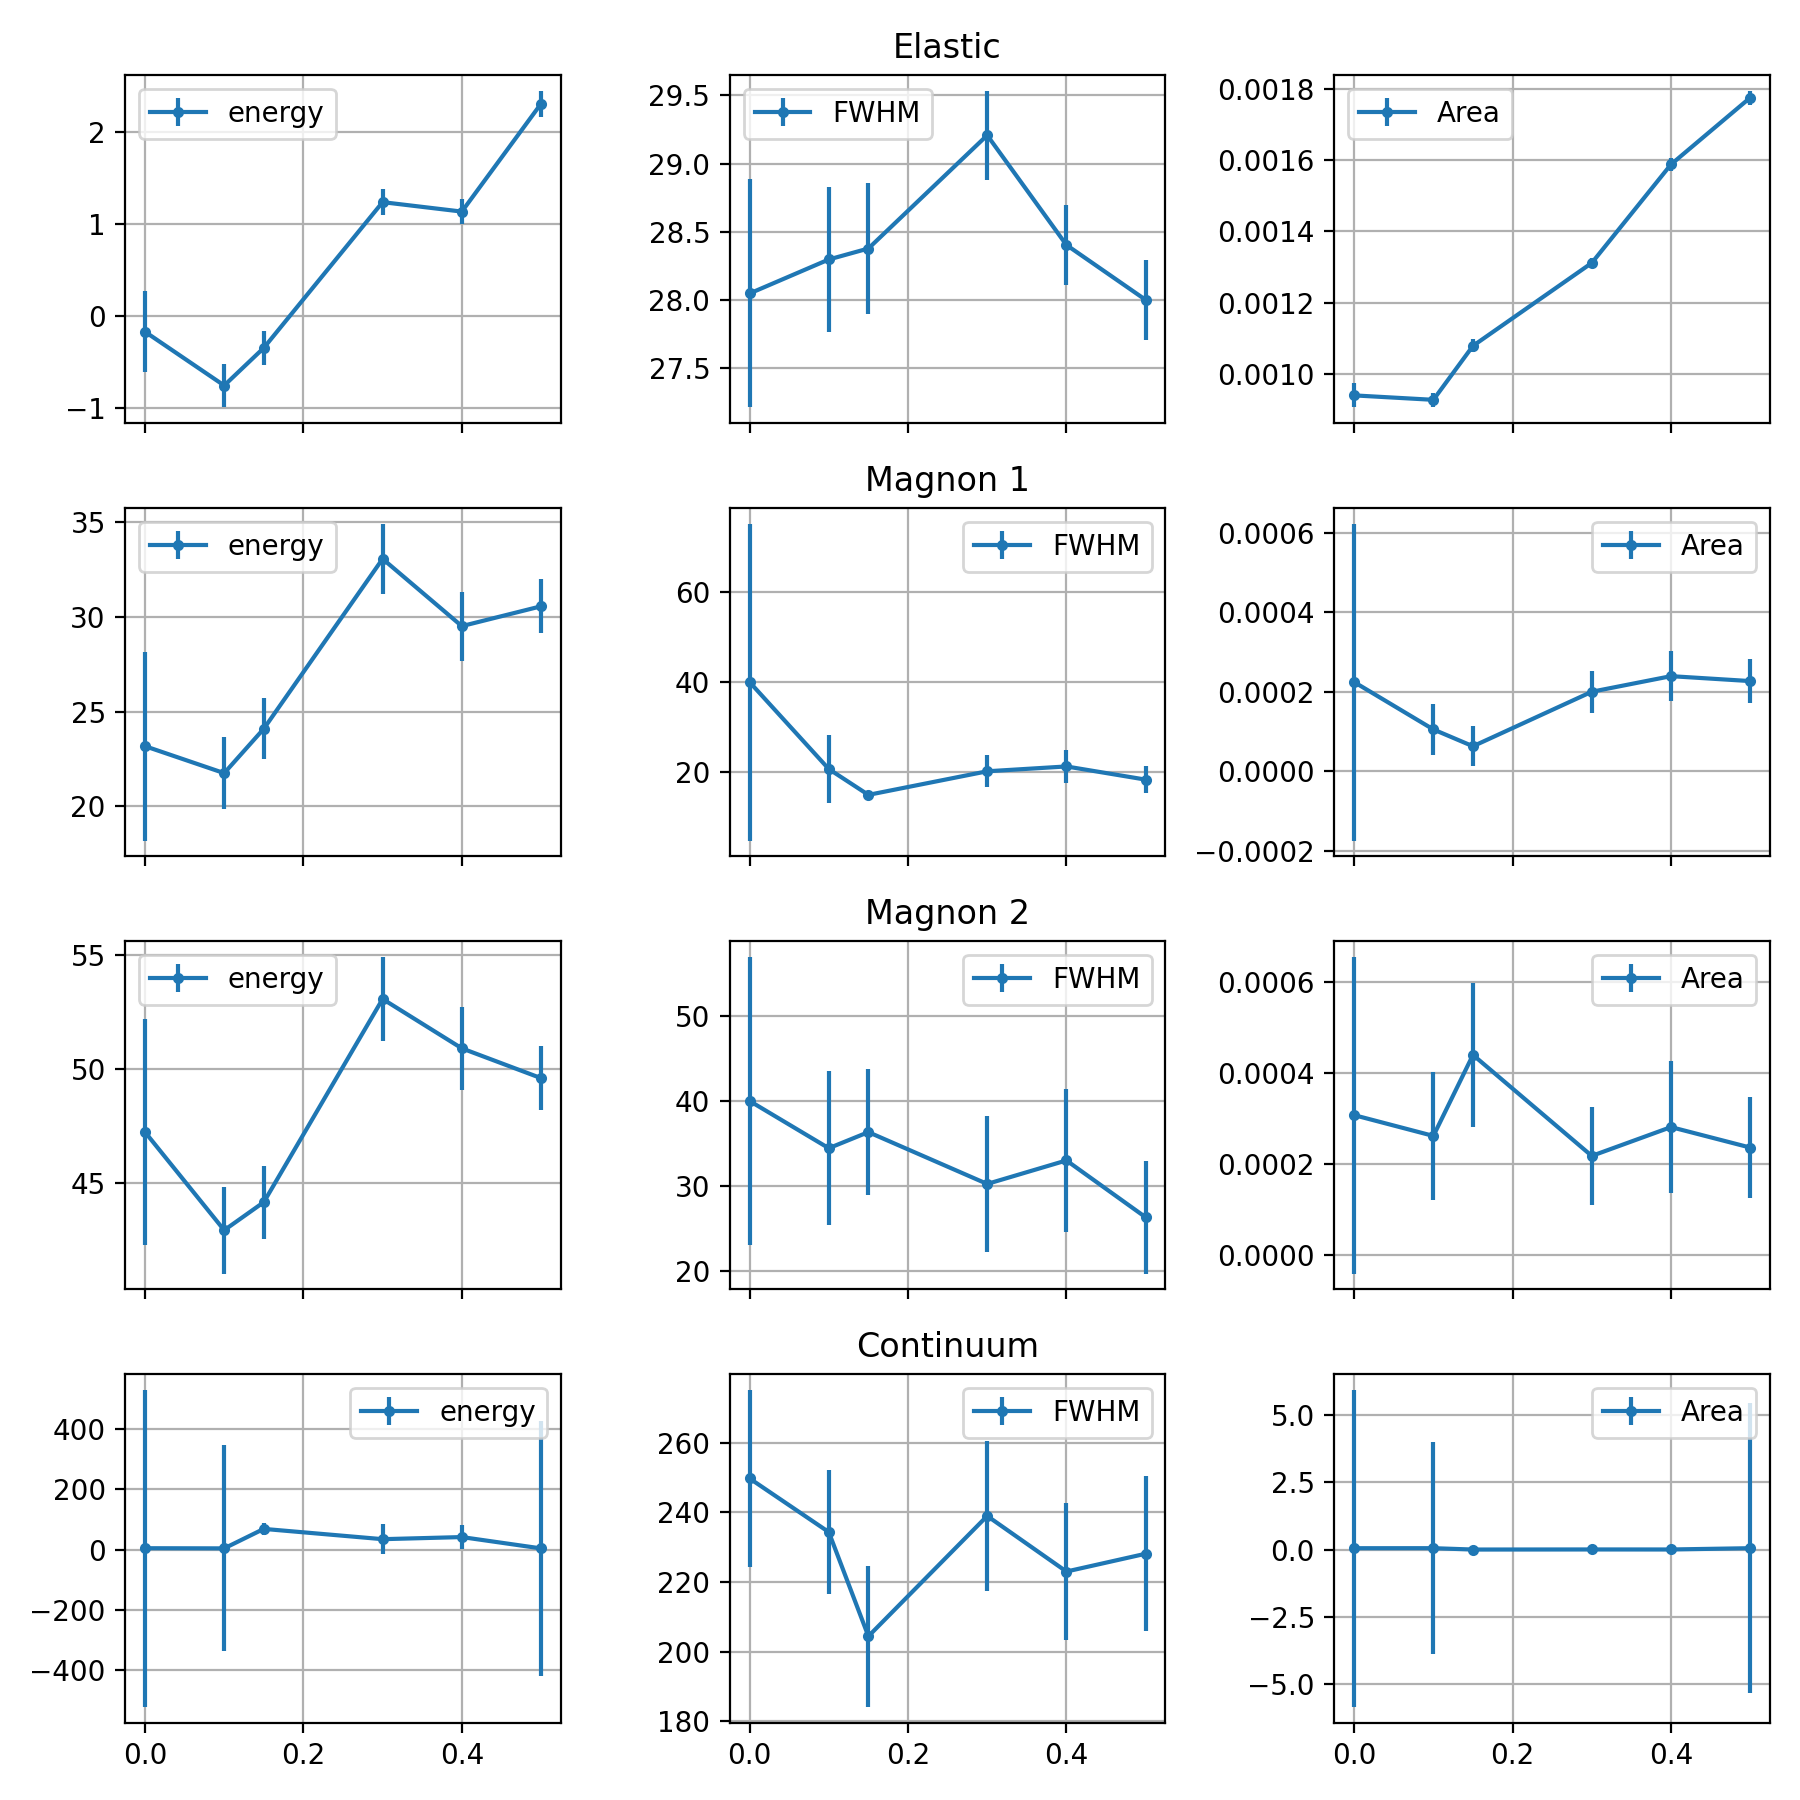

In [58]:
'''
elpks = np.array(elpks)
elpks_err = np.array(elpks_err)
elpkwids_ALor = np.array(elpkwids)
elpkwids_ALor_err = np.array(elpkwids_err)
elpkAreas_ALor = np.array(elpkAreas)
elpkAreas_ALor_err = np.array(elpkAreas_err)

magpks_ALor = np.array(magpks_ALor)
magpks_ALor_err = np.array(magpks_ALor_err)
magpkwids_ALor = np.array(magpkwids_ALor)
magpkwids_ALor_err = np.array(magpkwids_ALor_err)
magpkAreas_ALor = np.array(magpkAreas_ALor)
magpkAreas_ALor_err = np.array(magpkAreas_ALor_err)

conpks_ALor = np.array(conpks_ALor)
conpks_ALor_err = np.array(conpks_ALor_err)
conpkwids_ALor = np.array(conpkwids_ALor)
conpkwids_ALor_err = np.array(conpkwids_ALor_err)
conpkAreas_ALor = np.array(conpkAreas_ALor)
conpkAreas_ALor_err = np.array(conpkAreas_ALor_err)
'''

# for plotting
k = np.array([0.5, 0.4, 0.3, 0.15, 0.1, 0])

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9),(ax10, ax11, ax12)) = plt.subplots(4, 3, sharex=True, figsize=(9, 9))

#ax1.errorbar(T, elpks, yerr=elpks_err, fmt='.-', label='energy')
ax1.errorbar(k, elpks, yerr=elpks_err, fmt='.-', label='energy')
ax1.grid('True')
ax1.legend()

#ax2.errorbar(T, elpkwids_ALor, yerr=elpkwids_ALor_err, fmt='.-', label='FWHM')
ax2.errorbar(k, elpkwids_ALor, yerr=elpkwids_ALor_err, fmt='.-', label='FWHM')
ax2.grid('True')
ax2.set_title('Elastic')
ax2.legend()

#ax3.errorbar(T, elpkAreas_ALor, yerr=elpkAreas_ALor_err, fmt='.-', label='Area')
ax3.errorbar(k, elpkAreas_ALor, yerr=elpkAreas_ALor_err, fmt='.-', label='Area')
ax3.grid('True')
ax3.legend()

#ax4.errorbar(T, magpks_ALor-elpks, yerr=magpks_ALor_err, fmt='.-', label='energy')
ax4.errorbar(k, magpks_ALor-elpks, yerr=magpks_ALor_err, fmt='.-', label='energy')
ax4.grid('True')
ax4.legend()

#ax5.errorbar(T, magpkwids_ALor, yerr=magpkwids_ALor_err, fmt='.-', label='FWHM')
ax5.errorbar(k, magpkwids_ALor, yerr=magpkwids_ALor_err, fmt='.-', label='FWHM')
ax5.grid('True')
ax5.set_title('Magnon 1')
ax5.legend()

#ax6.errorbar(T, magpkAreas_ALor, yerr=magpkAreas_ALor_err, fmt='.-', label='Area')
ax6.errorbar(k, magpkAreas_ALor, yerr=magpkAreas_ALor_err, fmt='.-', label='Area')
ax6.grid('True')
ax6.legend()

#ax7.errorbar(T, mag2pks_ALor-elpks, yerr=mag2pks_ALor_err, fmt='.-', label='energy')
ax7.errorbar(k, mag2pks_ALor-elpks, yerr=mag2pks_ALor_err, fmt='.-', label='energy')
ax7.grid('True')
ax7.legend()

#ax8.errorbar(T, mag2pkwids_ALor, yerr=mag2pkwids_ALor_err, fmt='.-', label='FWHM')
ax8.errorbar(k, mag2pkwids_ALor, yerr=mag2pkwids_ALor_err, fmt='.-', label='FWHM')
ax8.grid('True')
ax8.set_title('Magnon 2')
ax8.legend()

#ax9.errorbar(T, mag2pkAreas_ALor, yerr=mag2pkAreas_ALor_err, fmt='.-', label='Area')
ax9.errorbar(k, mag2pkAreas_ALor, yerr=mag2pkAreas_ALor_err, fmt='.-', label='Area')
ax9.grid('True')
ax9.legend()

#ax10.errorbar(T, conpks_ALor-elpks, yerr=conpks_ALor_err, fmt='.-', label='energy')
ax10.errorbar(k, conpks_ALor-elpks, yerr=conpks_ALor_err, fmt='.-', label='energy')
ax10.grid('True')
ax10.legend()

#ax11.errorbar(T, conpkwids_ALor, yerr=conpkwids_ALor_err, fmt='.-', label='FWHM')
ax11.errorbar(k, conpkwids_ALor, yerr=conpkwids_ALor_err, fmt='.-', label='FWHM')
ax11.grid('True')
ax11.set_title('Continuum')
ax11.legend()

#ax12.errorbar(T, conpkAreas_ALor, yerr=conpkAreas_ALor_err, fmt='.-', label='Area')
ax12.errorbar(k, conpkAreas_ALor, yerr=conpkAreas_ALor_err, fmt='.-', label='Area')
ax12.grid('True')
ax12.legend()

plt.tight_layout()
plt.show()

In [61]:
df = pd.DataFrame({"k positions" : k, 
                   "el pk" : elpks, "el pk err" : elpks_err, "el width" : elpkwids_ALor, "el width err" : elpkwids_ALor_err,
                   "el area" : elpkAreas_ALor, "el area err" : elpkAreas_ALor_err,
                   "mag1 pk" : magpks_ALor, "mag1 pk err" : magpks_ALor_err, "mag1 width" : magpkwids_ALor, 
                   "mag1 width err" : magpkwids_ALor_err, "mag1 area" : magpkAreas_ALor, "mag1 area err" : magpkAreas_ALor_err,
                   "mag2 pk" : mag2pks_ALor, "mag2 pk err" : mag2pks_ALor_err, "mag2 width" : mag2pkwids_ALor, 
                   "mag2 width err" : mag2pkwids_ALor_err, "mag2 area" : mag2pkAreas_ALor, "mag2 area err" : mag2pkAreas_ALor_err,
                   "cont pk" : conpks_ALor, "cont pk err" : conpks_ALor_err, "cont width" : conpkwids_ALor, "cont width err" : conpkwids_ALor_err,
                   "cont area" : conpkAreas_ALor, "cont area err" : conpkAreas_ALor_err})

df.to_csv("YIO100nm_dispersion_fit_values.csv", index=False)